# Identify Prostate Cancer Biomarker using Machine Learning

#### Fan Wang
#### July 5 2022

This notebook demonstrates the analysis of The Cancer Genome Atlas Prostate Adenocarcinoma (TCGA-PRAD) gene expression dataset to understand the steps in a differential expression analysis workflow in the context of DESeq2.

The goal of this analysis is to find differences in gene expression profiles between the two sample populations: normal cells versus tumor cells. The two groups will be compared through an analysis of TCGA-PRAD gene expression dataset downloaded from the NCI's Genomic Data Commons (GDC). The dataset contains expression values (sequence counts) generated via the Illumina HiSeq platform.


## [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) analysis workflow

Summary of the Differential Expression Analysis Workflow:

> - Install and import necessary packages and functions. Download data.
> - Identify genes whose expression levels change significantly between tumor and normal samples.
> - Preprocess dataset by filtering out the gene genes with zero values.
> - Split expression dataset to tumor samples dataframe and normal samples dataframe.
> - Generate metaData.
> - Call the DESeqDataSetFromMatrix function and DESeq function to get results


---------------

## Load required packages

In [1]:
options(warn=-1)

In [3]:
library(TCGAbiolinks)
library(DESeq2)
library(SummarizedExperiment)
library(ggplot2)

## Load functions for identifying upregulated and downregulated genes

In [4]:
get_upregulated <- function(df) {
  key <- intersect(rownames(df)[which(df$log2FoldChange >= 1)],
                   rownames(df)[which(df$pvalue <= 0.05)])
  
  results <- as.data.frame((df)[which(rownames(df) %in% key), ])
  return(results)
}

In [5]:
get_downregulated <- function(df) {
  key <- intersect(rownames(df)[which(df$log2FoldChange <= -1)],
                   rownames(df)[which(df$pvalue <= 0.05)])
  
  results <- as.data.frame((df)[which(rownames(df) %in% key), ])
  return(results)
}

## Download data from GDC

In [6]:
query <- GDCquery(project = "TCGA-PRAD", 
                  data.category = "Gene expression",
                  data.type = "Gene expression quantification",
                  experimental.strategy = "RNA-Seq",
                  platform = "Illumina HiSeq",
                  file.type = "results",
                  legacy = TRUE)

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg19

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-PRAD

--------------------

oo Filtering results

--------------------

ooo By platform

ooo By experimental.strategy

ooo By data.type

ooo By file.type

----------------

oo Checking data

----------------

ooo Check if there are duplicated cases

ooo Check if there results for the query

-------------------

o Preparing output

-------------------



In [7]:
dir.create("./Data")
GDCdownload(
  query,
  method = "api",
  files.per.chunk = 100,
  directory = "./Data"
)


GDCdownload will download 550 files. A total of 834.121914 MB




Downloading: 61 MB      

Downloading: 61 MB        

Downloading: 61 MB      

Downloading: 61 MB      

Downloading: 61 MB        

Downloading: 30 MB        

In [8]:
mrna_df <- GDCprepare(query, directory = "./Data")

--------------------

oo Reading 550 files

--------------------



|====================================================|100%                      Completed after 16 s 


--------------------

oo Merging 550 files

--------------------

Starting to add information to samples

 => Add clinical information to samples

 => Adding TCGA molecular information from marker papers

 => Information will have prefix 'paper_' 

prad subtype information from:doi:10.1016/j.cell.2015.10.025



## Preprocess data

In [9]:
### remove columns we dont need, keep counts
mrna_meta <- mrna_df$sample
mrna_meta <- cbind(mrna_meta, mrna_df$definition)
mrna_df <- assay(mrna_df)
delim_fn = function(x, n, i) {
  do.call(c, lapply(x, function(X)
    paste(unlist(strsplit(
      X, "-"
    ))[(n + 1):(i)], collapse = "-")))
}
colnames(mrna_df) <- delim_fn(x = colnames(mrna_df), n = 0, i = 4)
mrna_meta <- as.data.frame(mrna_meta)
mrna_df <- as.data.frame(mrna_df)

In [10]:
## Remove metastatic sample
metastatic_key <- mrna_meta[which(mrna_meta[, 2] == "Metastatic"), ]
mrna_meta <- mrna_meta[!mrna_meta[, 2] == metastatic_key[, 2], ]
mrna_df <-
  mrna_df[,-grep(paste0(metastatic_key[, 1]), colnames(mrna_df))]
mrna_meta[, 2] <- as.character(mrna_meta[, 2])
mrna_meta[, 2] <-
  gsub("Primary solid Tumor", "Tumor", mrna_meta[, 2])
mrna_meta[, 2] <-
  gsub("Solid Tissue Normal", "Normal", mrna_meta[, 2])
mrna_meta[, 2] <- as.factor(mrna_meta[, 2])
levels(mrna_meta[, 2])
colnames(mrna_meta) <- c("cases", "Condition")

[1] "Normal" "Tumor"

## Execute differential expression analysis using [DESeq2](https://github.com/mikelove/DESeq2)

In [11]:
mrna_dds <-
  DESeqDataSetFromMatrix(round(mrna_df),
                         colData = mrna_meta,
                         design = ~ Condition)

converting counts to integer mode



#### Everything from normalization to linear modeling was carried out by the use of a single function `DESeq`. This function will print out a message for the various steps it performs:
```
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
```

In [12]:
mrna_dds$Condition <- relevel(mrna_dds$Condition, ref = "Normal")
mrna_dds <- DESeq(mrna_dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1439 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



,TCGA-G9-7525-01A,TCGA-EJ-7789-01A,TCGA-EJ-7314-11A,TCGA-HC-8265-01A,TCGA-EJ-A46B-01A,TCGA-HC-7819-01A,TCGA-EJ-5510-01A,TCGA-HC-7080-01A,TCGA-CH-5769-11A,TCGA-KK-A7AY-01A,⋯,TCGA-G9-6377-01A,TCGA-V1-A8MF-01A,TCGA-G9-6499-11A,TCGA-J4-A67R-01A,TCGA-KK-A6E7-01A,TCGA-J9-A8CN-01A,TCGA-CH-5762-01A,TCGA-XJ-A9DX-01A,TCGA-KK-A6E5-01A,TCGA-EJ-5496-01A
A1BG|1,6.008894,7.355672,7.672604,7.907780,7.380921,6.189704,6.560988,5.889730,6.145200,6.520872,⋯,6.584258,6.959848,6.889952,7.406567,6.830122,6.074995,5.411722,8.238785,7.448119,5.840184
A2M|2,14.977996,14.768960,16.052200,14.783020,13.568532,13.518895,14.263595,14.022247,14.657321,14.457274,⋯,13.784273,14.996586,15.086310,14.495920,14.170037,14.425412,15.190929,13.686582,14.506364,13.316533
NAT1|9,7.369287,5.967220,8.657079,8.214435,9.172845,5.967724,8.689489,6.183797,8.645634,5.524921,⋯,8.042378,8.220037,9.312656,7.235903,9.267809,9.088459,7.819305,5.980150,9.675646,7.288150
NAT2|10,5.153428,4.052769,5.213812,4.687886,5.166692,4.522975,5.095599,5.115032,5.176564,4.514181,⋯,4.859166,5.722875,5.025388,5.173697,6.807294,4.465588,4.052769,4.052769,4.774214,4.706704
SERPINA3|12,16.425500,8.755545,14.887241,16.042970,10.837725,14.793632,15.035991,12.389362,15.395851,12.833889,⋯,15.029958,10.727668,14.168768,16.990727,10.022932,14.148247,13.947195,10.260316,12.506878,14.000804
AADAC|13,4.408430,4.052769,4.558712,4.052769,4.052769,4.052769,4.359825,4.052769,4.521184,4.052769,⋯,4.052769,4.052769,4.052769,4.591437,4.518895,4.052769,4.052769,4.052769,4.416300,4.052769


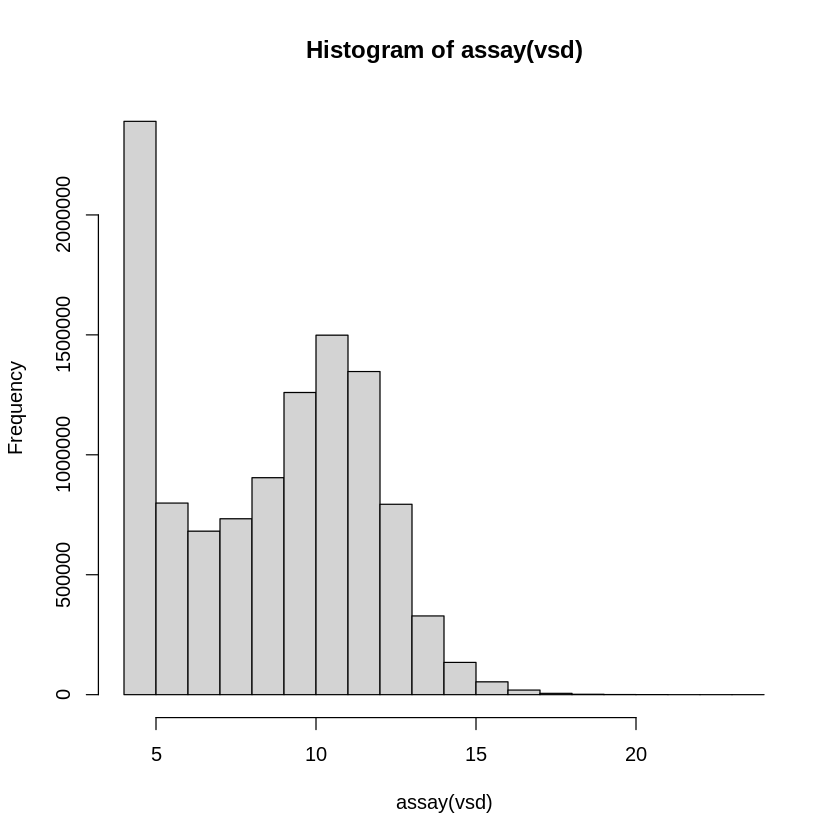

In [13]:
vsd <- varianceStabilizingTransformation(mrna_dds, blind = FALSE)
head(assay(vsd))
hist(assay(vsd))

In [14]:
resultsNames(mrna_dds)

[1] "Intercept"                 "Condition_Tumor_vs_Normal"

## Dispersion Plot

Dispersion is a measure of spread or variability in the data. Variance, standard deviation, IQR, among other measures, can all be used to measure dispersion. However, DESeq2 uses a specific measure of dispersion (α) related to the mean (μ) and variance of the data:   

> Var = μ + α * μ^2 

For genes with moderate to high count values, the square root of dispersion will be equal to the coefficient of variation (Var / μ). So 0.01 dispersion means 10% variation around the mean expected across biological replicates.

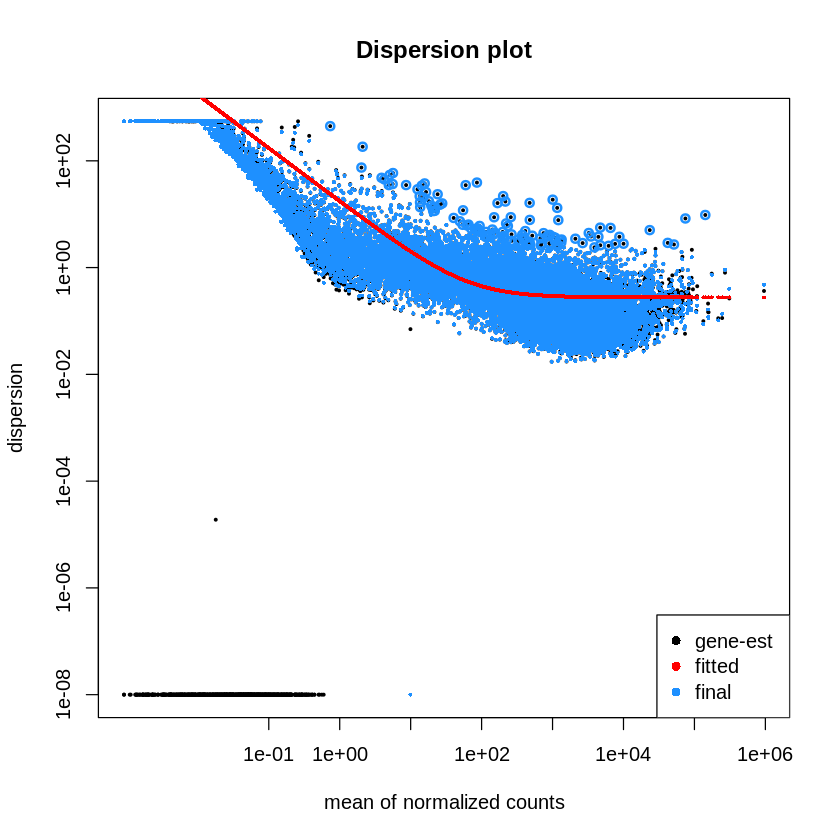

In [15]:
# Plot Dispersions:
plotDispEsts(mrna_dds, main = "Dispersion plot")

##### This curve is displayed as a red line in the figure below, which plots the estimate for the ***expected dispersion value for genes of a given expression strength***. 

##### Each black dot is a gene with an associated mean expression level and maximum likelihood estimation (MLE) of the dispersion

## MA Plot

MA plot is a scatter plot of log2 fold changes (M) on the y-axis versus the mean of normalized expression counts on the x-axis.

Generally, genes with lower mean expression values will have highly variable log fold changes. Genes with similar expression values in both normal and treated samples will cluster around M=0 value i.e genes expressed with no significant differences in between groups. Points away from `M=0` line indicate genes with significant expression, For example, a gene is upregulated and downregulated if the point is above and below `M=0` line respectively.

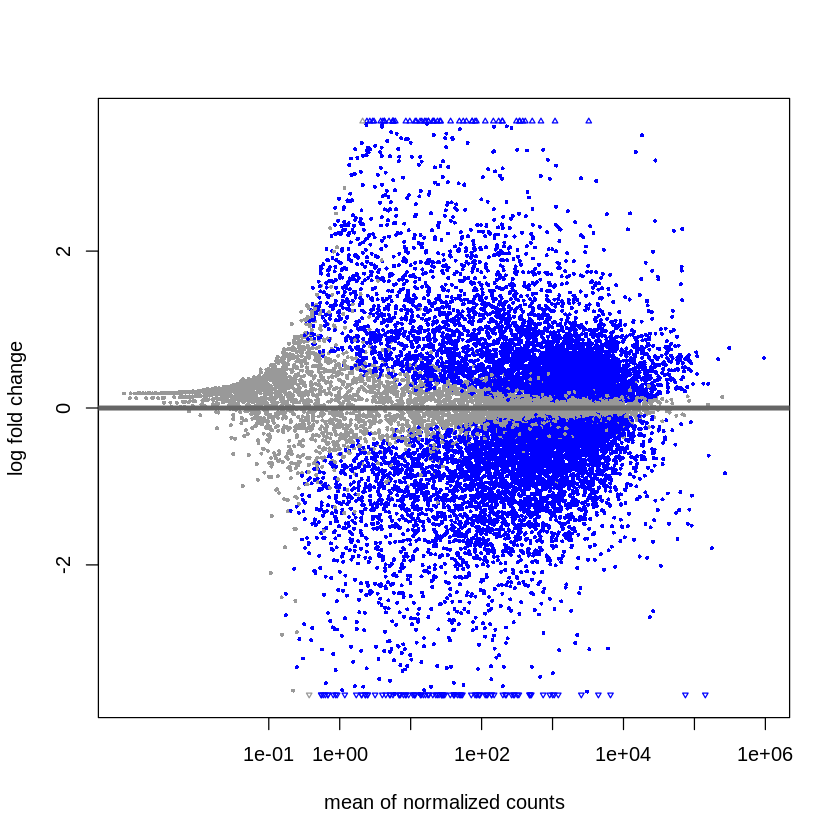

In [16]:
mrna_res <- results(mrna_dds, name = "Condition_Tumor_vs_Normal")
plotMA(mrna_res)

### Statistics summary 

In [17]:
mrna_res_df <- as.data.frame(mrna_res)
mrnaTable <- mrna_res_df
mrnaTable$Gene_id <- rownames(mrnaTable)
summary(mrna_res)


out of 19669 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 6878, 35%
LFC < 0 (down)     : 6338, 32%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



### Volcano Plot

MA plot does not consider statistical measures (p values or adjusted p values) and therefore we can not tell genes with statistically significant differences between normal vs. tumor from MA plot. And that is why we use Volcano plot to indicate genes with statistically significant differences.

In [18]:
mrna_upreg <- get_upregulated(mrna_res)
mrna_downreg <- get_downregulated(mrna_res)
mrna_counts <- counts(mrna_dds, normalized = T)
mrna_upreg$Gene_id <- rownames(mrna_upreg)
mrna_downreg$Gene_id <- rownames(mrna_downreg)
mrna_res_df$Gene_id <- rownames(mrna_res_df)

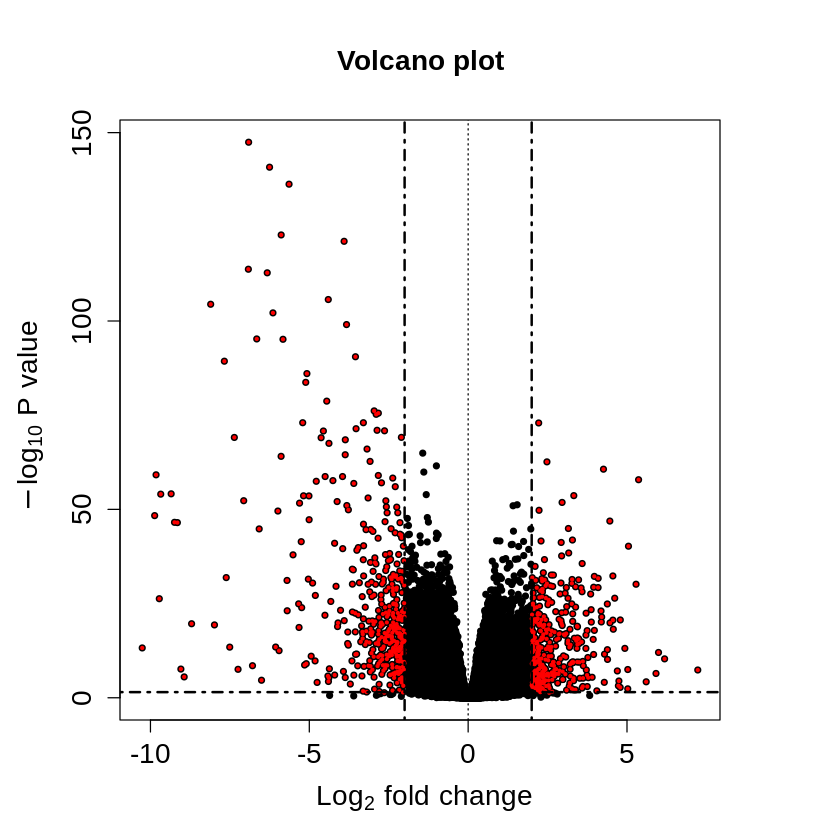

In [19]:
par(
  mar = c(5, 5, 5, 5),
  cex = 1.0,
  cex.main = 1.4,
  cex.axis = 1.4,
  cex.lab = 1.4
)
with(
  mrna_res_df,
  plot(
    log2FoldChange,
    -log10(padj),
    pch = 20,
    main = "Volcano plot",
    cex = 1.0,
    xlab = bquote( ~ Log[2] ~ fold ~ change),
    ylab = bquote( ~ -log[10] ~ P ~ value)
  )
)

with(
  subset(mrna_res_df, padj < 0.05 &
           abs(log2FoldChange) > 2),
  points(
    log2FoldChange,
    -log10(padj),
    pch = 20,
    col = "red",
    cex = 0.5
  )
)

#Add lines for absolute FC>2 and P-value cut-off at FDR Q<0.05
abline(v = 0,
       col = "black",
       lty = 3,
       lwd = 1.0)
abline(v = -2,
       col = "black",
       lty = 4,
       lwd = 2.0)
abline(v = 2,
       col = "black",
       lty = 4,
       lwd = 2.0)
abline(
  h = -log10(max(mrna_res_df$pvalue[mrna_res_df$padj < 0.05], na.rm = TRUE)),
  col = "black",
  lty = 4,
  lwd = 2.0
)

## Conclusion

The set of genes found to be differentially expressed, namely ANGPT1, CHRM2, HSPA6, KIRREL3, C2orf88, SMR3A, CIDEC, ZNF185, FAM167A, APOBEC3C, EPHA10, HOXC4, NETO2, GTSE1, NETO1, KISS1R, TEKT1, ACTL8, ROPN1L, could be deduced from the above results. The genes ANGPT1, APOBEC3C, ZNF185, EPHA10, and HOXC4 have the potential to be used as diagnostic tests for prostate cancer early detection. These genes will need to be studied further to see if they may be fused with other genes to boost their selectivity and specificity. Because prostate cancer is a potentially fatal malignancy for the majority of men who are diagnosed with it, the only way to solve this issue is through early detection and accurate prognosis, which is what our research attempts to achieve.

### Reference 

In [20]:
citation("DESeq2")


  Love, M.I., Huber, W., Anders, S. Moderated estimation of fold change
  and dispersion for RNA-seq data with DESeq2 Genome Biology 15(12):550
  (2014)

A BibTeX entry for LaTeX users is

  @Article{,
    title = {Moderated estimation of fold change and dispersion for RNA-seq data with DESeq2},
    author = {Michael I. Love and Wolfgang Huber and Simon Anders},
    year = {2014},
    journal = {Genome Biology},
    doi = {10.1186/s13059-014-0550-8},
    volume = {15},
    issue = {12},
    pages = {550},
  }
